## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import seaborn as sns
import cv2


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install -q tensorflow-gpu==2.0.0-beta1


In [0]:
# import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop


In [0]:
tf.__version__

'1.14.0'

## Helper Functions

### Helper-function for joining a directory and list of filenames.

In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Helper-function for printing confusion matrix

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):

    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred)

    print("Confusion matrix:")
    print(cm)
    
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, 
                square=True, cmap='Blues_r');
    plt.xticklabels=class_names;
    plt.yticklabels=class_names;
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix');
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [0]:
def plot_example_errors(cls_pred):

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [0]:
def example_errors():
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred, axis=1) #np.array([1 if pred >= 0.5 else 0 for pred in y_pred])

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values.

In [0]:
def plot_training_history(history):
  
    acc = history.history['acc']
    loss = history.history['loss']

    val_acc = history.history['acc']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

## PriceHubble Dataset


Connect Colab with Google drive:

In [0]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dir = '../gdrive/My Drive/classified/kit/train'
test_dir = '../gdrive/My Drive/classified/kit/test'

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If `include_top=True` then the whole VGG16 model is downloaded. If `include_top=False` then only the convolutional part of the VGG16.

In [0]:
model = VGG16(include_top=True, weights='imagenet')

W0729 07:03:58.192281 140251172886400 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


553467904/553467096 [==============================] - 36s 0us/step


## Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

The shape of the tensors expected as input by the pre-trained VGG16 model is 224 x 224 x 3.

In [0]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Define a data-generator for the training set doing some transformations.

In [0]:
datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [0]:
batch_size_train = 32
batch_size_test = 16

Create the actual data-generator that will read files from disk, resize the images and return a random batch.


In [0]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size_train,
                                                    shuffle=True,
                                                    class_mode='categorical')
                                        

Found 896 images belonging to 2 classes.


The data-generator for the test-set should not transform and shuffle the images.

In [0]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size_test,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 224 images belonging to 2 classes.


Specify the number of steps to perform during evaluation and prediction on the test-set.

In [0]:
steps_test = generator_test.n / batch_size_test
steps_test

14.0

Get the file-paths for all the images in the training- and test-sets.

In [0]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [0]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [0]:
class_names = list(generator_train.class_indices.keys())
class_names

['simple-kit', 'top-kit']

Get the number of classes for the dataset.

In [0]:
num_classes = generator_train.num_classes
num_classes

2

### Plot a few images to see if data is correct

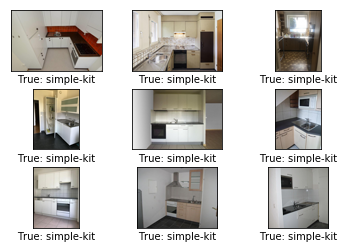

In [0]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [0]:
class_weight

array([1., 1.])

In [0]:
class_names

['simple-kit', 'top-kit']

## Transfer Learning

The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. We can try to re-route the output of the last convolutional layer of the VGG16 model to a new fully-connected neural network that we create for doing classification on the PriceHubble dataset.

First we print a summary of the VGG16 model so we can see the names and types of its layers, as well as the shapes of the tensors flowing between the layers.

In [0]:
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.

In [0]:
transfer_layer = model.get_layer('block5_pool')

In [0]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

Using the Keras API it is very simple to create a new model. First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the VGG16 model.

In [0]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

We can then use Keras to build a new model on top of this.

In [0]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a conv layer.
new_model.add(Flatten())

# Add a dense (fully-connected) layer.
# This combines features that the VGG16 model has recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting.
new_model.add(Dropout(0.25))

# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

Chose optimizer.
If you train more layers of the original VGG16 model, the learning-rate should be quite low otherwise the pre-trained weights of the VGG16 model will be distorted and it will be unable to learn.

In [0]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 40,407,874
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = Adam(lr=1e-3)

Chose loss function.

In [0]:
loss = 'categorical_crossentropy'

Chose performance metric.

In [0]:
metrics = ['categorical_accuracy']

Helper-function for printing whether a layer in the VGG16 model should be trained.

In [0]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

By default all the layers of the VGG16 model are trainable.

In [0]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In Transfer Learning, reuse the pre-trained VGG16 model as it is, so disable training for all its layers.

In [0]:
conv_model.trainable = False

In [0]:
for layer in conv_model.layers:
    layer.trainable = False

In [0]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


Compile the model for the changes to take effect.

In [0]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Define epochs and steps per epoch for the training-set.

In [0]:
epochs = 10
steps_per_epoch = generator_train.n / batch_size_train
steps_per_epoch

28.0

In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/10
28/28 [==============================] - 590s 21s/step - loss: 3.5514 - categorical_accuracy: 0.5949 - val_loss: 0.3147 - val_categorical_accuracy: 0.8839
Epoch 2/10
28/28 [==============================] - 20s 714ms/step - loss: 0.8192 - categorical_accuracy: 0.7623 - val_loss: 0.2157 - val_categorical_accuracy: 0.9152
Epoch 3/10
28/28 [==============================] - 26s 912ms/step - loss: 0.4400 - categorical_accuracy: 0.8170 - val_loss: 0.1974 - val_categorical_accuracy: 0.9241
Epoch 4/10
28/28 [==============================] - 26s 913ms/step - loss: 0.3728 - categorical_accuracy: 0.8359 - val_loss: 0.1906 - val_categorical_accuracy: 0.9196
Epoch 5/10
28/28 [==============================] - 26s 916ms/step - loss: 0.2571 - categorical_accuracy: 0.8951 - val_loss: 0.1636 - val_categorical_accuracy: 0.9330
Epoch 6/10
28/28 [==============================] - 25s 909ms/step - loss: 0.2769 - categorical_accuracy: 0.8694 - val_loss: 0.2114 - val_categorical_accuracy: 0.9152

Keras records the performance metrics at the end of each "epoch" so they can be plotted later. 

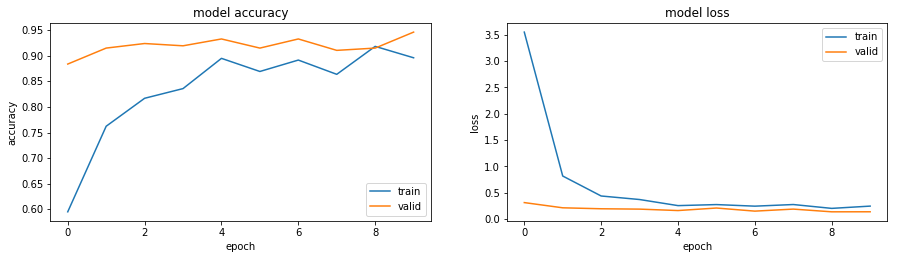

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
#plot_training_history(history)

Evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 94.64%


Plot some examples of mis-classified images from the test-set.

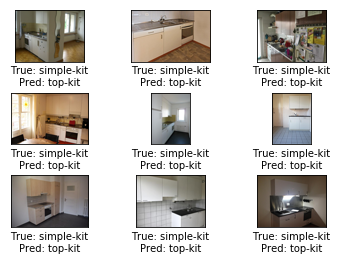

Confusion matrix:
[[103   9]
 [  3 109]]
(0) simple-kit
(1) top-kit


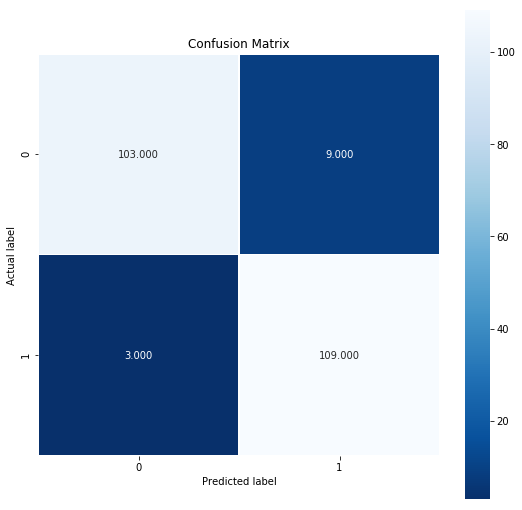

In [0]:
example_errors()

## Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change.

Once the new classifier has been trained, fine-tune some of the deeper layers in the VGG16 model.

In [0]:
conv_model.trainable = True

Train the last convolutional layers.

In [0]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name) #or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

Check that this has updated the `trainable` boolean for the relevant layers.

In [0]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Use a lower learning-rate for the fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [0]:
optimizer_fine = Adam(lr=1e-5)

Recompile the model so the changes can take effect before we continue training.

In [0]:
loss_tune = 'categorical_crossentropy'

In [0]:
new_model.compile(optimizer=optimizer_fine, loss=loss_tune, metrics=metrics)

The training can then be continued so as to fine-tune the VGG16 model along with the new classifier.

In [0]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)


Epoch 1/10
28/28 [==============================] - 29s 1s/step - loss: 0.1925 - categorical_accuracy: 0.9152 - val_loss: 0.1121 - val_categorical_accuracy: 0.9598
Epoch 2/10
28/28 [==============================] - 26s 931ms/step - loss: 0.1601 - categorical_accuracy: 0.9397 - val_loss: 0.1110 - val_categorical_accuracy: 0.9464
Epoch 3/10
28/28 [==============================] - 26s 923ms/step - loss: 0.1234 - categorical_accuracy: 0.9487 - val_loss: 0.1014 - val_categorical_accuracy: 0.9598
Epoch 4/10
28/28 [==============================] - 26s 935ms/step - loss: 0.1155 - categorical_accuracy: 0.9509 - val_loss: 0.0984 - val_categorical_accuracy: 0.9643
Epoch 5/10
28/28 [==============================] - 26s 916ms/step - loss: 0.1334 - categorical_accuracy: 0.9364 - val_loss: 0.1227 - val_categorical_accuracy: 0.9420
Epoch 6/10
28/28 [==============================] - 26s 924ms/step - loss: 0.1236 - categorical_accuracy: 0.9498 - val_loss: 0.1582 - val_categorical_accuracy: 0.9196
E

Plot the loss-values and classification accuracy from the training.

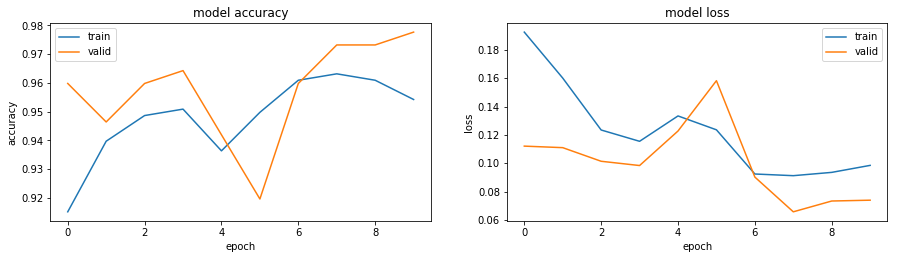

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [0]:
#plot_training_history(history)

In [0]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 97.77%


Plot some examples of mis-classified images again.

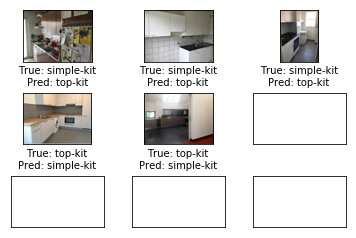

Confusion matrix:
[[109   3]
 [  2 110]]
(0) simple-kit
(1) top-kit


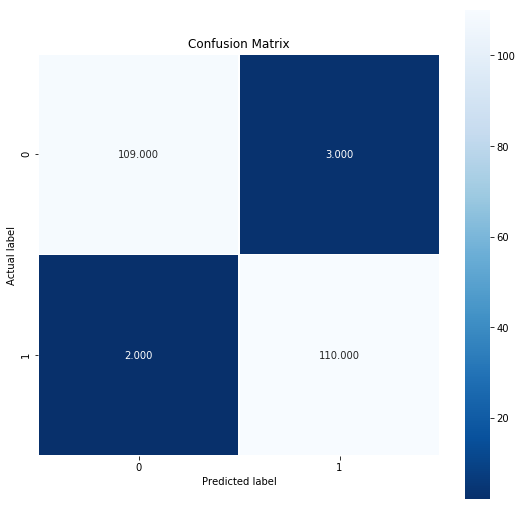

In [0]:
example_errors()

## Predicting unseen images

In [0]:
def predict(model, image_path, class_names):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot the image.
    plt.imshow(img)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.zeros((1, 224, 224, 3))
    img_array[0, :, :, :] = img / 255.

    # Use the VGG16 model to make a prediction.
    pred = new_model.predict_proba(img_array)
    
    print (pred)

    for ind, score in enumerate(pred[0]):
      print("{0:>6.2%} {1}".format(score, class_names[ind]))
   

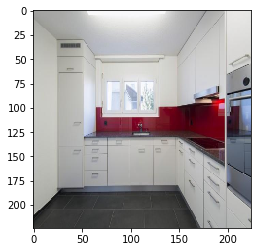

[[2.7707886e-04 9.9972290e-01]]
 0.03% simple-kit
99.97% top-kit


In [0]:
img_p = '../gdrive/My Drive/pred-test/kit/5b0a6113643cf51112eca0e4d2f58329f1284d1c.jpg'
predict(model=new_model, image_path=img_p, class_names=class_names)


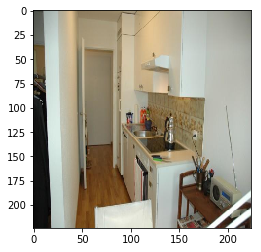

[[0.9988776  0.00112242]]
99.89% simple-kit
 0.11% top-kit


In [0]:
img_p = '../gdrive/My Drive/pred-test/kit/4d548d64f63d94f05a36f116b967f4a4ad338001.jpg'
predict(model=new_model, image_path=img_p, class_names=class_names)


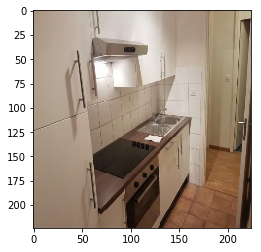

[[0.72553325 0.2744668 ]]
72.55% simple-kit
27.45% top-kit


In [0]:
img_p = '../gdrive/My Drive/pred-test/kit/3cdc7700809309557d8678edb5eca91106680746.jpg'
predict(model=new_model, image_path=img_p, class_names=class_names)

# Ps.: In this case, kitchen would be classified as normal, since model is not sure if it is simple or top, and in fact looks like a normal one.

## Code to save the model

In [0]:
# saving_model = tf.keras.models.save_model(
#    new_model,
#    '/gdrive/My Drive/Colab Notebooks/Models/vgg_binary_kit_94.h5py',
#    overwrite=True,
#    include_optimizer=True,
#    save_format=None)